#Step 0 - Install Cupy

In [33]:
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcusparse8.0 is already the newest version (8.0.61-1).
libnvrtc8.0 is already the newest version (8.0.61-1).
libnvtoolsext1 is already the newest version (8.0.61-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


# Step 1 - import module

In [0]:
# coding: utf-8
import pickle
import cupy as cp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
from collections import OrderedDict
#import keras

#print(tf.__version__)
#print(keras.__version__)

cp.random.seed(10)
np.random.seed(10)

# Step 2 - define functions

In [0]:
cp.random.seed(10)
np.random.seed(10)

# define def
def identify_function(x):
    return x

def step_function(x):
    return cp.array(x > 0, dtype=cp.int)

def sigmoid(x):
    return 1 / (1 + cp.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def relu(x):
    return cp.maximum(0, x)

def relu_grad(x):
    grad = cp.zeros(x)
    grad[x>=0] = 1
    return grad

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - cp.max(x, axis=0)
        y = cp.exp(x) / cp.sum(cp.exp(x), axis=0)
        return y.T 

    x = x - cp.max(x) # 오버플로 대책
    return cp.exp(x) / cp.sum(cp.exp(x))

def mean_squared_error(y, t):
    return 0.5 * cp.sum((y-t)**2)

# def cross_entropy_error(y, t):
#     delta = 1e-7
#     return -1 * cp.sum(t * cp.log(y + delta))
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -cp.sum(cp.log(y[cp.arange(batch_size), t] + 1e-7)) / batch_size
    
def softmax_loss(x,t):
    y = softmax(x)
    return cross_entropy_error(y, t)

def im2col(icput_data, filter_h, filter_w, stride=1, pad=0):

    N, C, H, W = icput_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = cp.pad(icput_data, [(0,0), (0,0), (pad, pad), (pad,pad)], 'constant')
    col = cp.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, icput_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = icput_shape
    out_h = (H + 2*pad - filter_h)//stride+1
    out_w = (W + 2*pad - filter_w)//stride+1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0,3,4,5,1,2)

    img = cp.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride -1))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] = col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

def numerical_gradient(f, x):
    h = 1e-4
    grad = cp.zeros_like(x)

    it = cp.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val
        it.iternext()

    return grad

# Step 3 - define optimizer
adam

In [0]:
cp.random.seed(10)
np.random.seed(10)

# coding: utf-8
import numpy as np

class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = cp.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = cp.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = cp.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (cp.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = cp.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (cp.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = cp.zeros_like(val)
                self.v[key] = cp.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * cp.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (cp.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (cp.sqrt(unbisa_b) + 1e-7)


# Step 4 - define trainer

In [0]:
cp.random.seed(10)
np.random.seed(10)

class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []
        
    def train_step(self):
        batch_mask = cp.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
#         if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))



# step 5 - define layer
relu, convolution, pooling, affine

In [0]:
cp.random.seed(10)
np.random.seed(10)

# define layer
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None

        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape # 텐서 대책이란?
        x = x.reshape(x.shape[0], -1) # reshape에서 -1의 의미는?
        self.x = x

        out = cp.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = cp.dot(dout, self.W.T)
        self.dW = cp.dot(self.x.T, dout)
        self.db = cp.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape) #입력 데이터 모양 변경 이유? 텐서 대응 how?
        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[cp.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        # for backward
        self.x = None
        self.col = None
        self.col_W = None

        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = cp.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = cp.sum(dout, axis=0)
        self.dW = cp.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = cp.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = cp.argmax(col, axis=1)
        out = cp.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = cp.zeros((dout.size, pool_size))
        dmax[cp.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx
      
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = cp.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask
      


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = cp.zeros(D)
            self.running_var = cp.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = cp.mean(xc**2, axis=0)
            std = cp.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((cp.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = cp.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -cp.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = cp.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

# Step 6 - define Convnet

In [0]:
cp.random.seed(10)
np.random.seed(10)

class DeepConvNet:
    """정확도 99% 이상의 고정밀 합성곱 신경망

    네트워크 구성은 아래와 같음
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':128, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':128, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':256, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_5 = {'filter_num':256, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':512, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=128, output_size=10):
        # 가중치 초기화===========
        # 각 층의 뉴런 하나당 앞 층의 몇 개 뉴런과 연결되는가（TODO: 자동 계산되게 바꿀 것）
        pre_node_nums = cp.array([1*3*3, 64*3*3, 128*3*3, 128*3*3, 256*3*3, 256*3*3, 512*3*3, hidden_size])
        wight_init_scales = cp.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * cp.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = cp.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * cp.random.randn(512*3*3, hidden_size)
        self.params['b7'] = cp.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * cp.random.randn(hidden_size, output_size)
        self.params['b8'] = cp.zeros(output_size)
        
        # 계층 생성===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad'])) #0
        self.layers.append(BatchNormalization(1.0, 0.0))
        self.layers.append(Relu())        
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad'])) #3
        self.layers.append(BatchNormalization(1.0, 0.0))
        self.layers.append(Relu())        
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad'])) #7
        self.layers.append(BatchNormalization(1.0, 0.0))
        self.layers.append(Relu())        
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad'])) #10
        self.layers.append(BatchNormalization(1.0, 0.0))
        self.layers.append(Relu())    
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad'])) #14
        self.layers.append(BatchNormalization(1.0, 0.0))
        self.layers.append(Relu())      
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad'])) #17
        self.layers.append(BatchNormalization(1.0, 0.0))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
                
        self.layers.append(Affine(self.params['W7'], self.params['b7'])) #21
        self.layers.append(BatchNormalization(1.0, 0.0))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.4))
        self.layers.append(Affine(self.params['W8'], self.params['b8'])) #25
        self.layers.append(Dropout(0.5))
        # 0, 3, 7, 10, 14, 17, 21, 25
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = cp.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = cp.argmax(y, axis=1)
            acc += cp.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 3, 7, 10, 14, 17, 21, 25)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 3, 7, 10, 14, 17, 21, 25)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]


# Step 7 - execute code

=== epoch:1, train acc:0.137, test acc:0.156 ===
=== epoch:2, train acc:0.857, test acc:0.839 ===
=== epoch:3, train acc:0.896, test acc:0.86 ===
=== epoch:4, train acc:0.895, test acc:0.869 ===
=== epoch:5, train acc:0.909, test acc:0.885 ===
=== epoch:6, train acc:0.906, test acc:0.888 ===
=== epoch:7, train acc:0.922, test acc:0.889 ===
=== epoch:8, train acc:0.921, test acc:0.89 ===
=== epoch:9, train acc:0.927, test acc:0.892 ===
=== epoch:10, train acc:0.929, test acc:0.905 ===
=== epoch:11, train acc:0.942, test acc:0.898 ===
=== epoch:12, train acc:0.935, test acc:0.898 ===
=== epoch:13, train acc:0.945, test acc:0.895 ===
=== epoch:14, train acc:0.938, test acc:0.894 ===
=== epoch:15, train acc:0.949, test acc:0.907 ===
=== epoch:16, train acc:0.956, test acc:0.908 ===
=== epoch:17, train acc:0.952, test acc:0.907 ===
=== epoch:18, train acc:0.954, test acc:0.907 ===
=== epoch:19, train acc:0.953, test acc:0.908 ===
=== epoch:20, train acc:0.958, test acc:0.917 ===
=== epoch:2

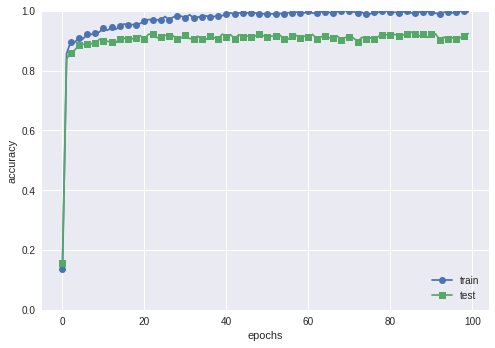

In [40]:
cp.random.seed(10)
np.random.seed(10)

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train=cp.expand_dims(x_train,axis=1)
x_test=cp.expand_dims(x_test,axis=1)

N = 30000

x_test = np.concatenate((x_test, x_train[N:]), axis=0)
t_test = np.concatenate((t_test, t_train[N:]), axis=0)

x_train = x_train[:N]
t_train = t_train[:N]

x_train.astype('float32') / 255
x_test.astype('float32') / 255

x_train.astype('float32') - 0.5
x_test.astype('float32') - 0.5

x_train.astype('float32') * 2
x_test.astype('float32') * 2

# cp 변환
x_train = cp.array(x_train)
x_test = cp.array(x_test)
t_train = cp.array(t_train)
t_test = cp.array(t_test)

max_epochs = 100


# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

network = DeepConvNet()  
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.0001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보관
network.save_params("deep_convnet_params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


#test acc:0.908625

## Tensorflow 1.10.1
## Keras 2.1.6 Using TensorFlow backend.

###Random seed 10
###100 epoch

#Accuracy Graph

![Result](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAe8AAAFcCAYAAADh1zYWAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4yLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvNQv5yAAAIABJREFUeJzt3XtcVHX+P/DXmRkQgeEmAwJeQEzJ%0Au4Sa4iVN3W62rVtqZXY126y10spcy8pAKyvL7Lt2se1n3kpZ19bSass0RdQsVLwkmgqi3OV+mZlz%0Afn8Ak8ScMwPMAQ7zej4e7TrzOXPmzYdhXvP5nM+cI0iSJIGIiIg0Q9faBRAREVHjMLyJiIg0huFN%0ARESkMQxvIiIijWF4ExERaQzDm4iISGNUDe9ff/0V48ePx6efftqgbe/evbj99tsxdepUrFy5Us0y%0AiIiI2hXVwru8vByLFy/G8OHD7ba/8sorWLFiBdavX489e/YgPT1drVKIiIjaFdXC29PTEx988AFC%0AQkIatGVkZMDf3x9hYWHQ6XQYM2YMkpOT1SqFiIioXVEtvA0GA7y8vOy25ebmIigoyHY7KCgIubm5%0AapVCRETUrhhauwBnWSxWGAz61i6DyKV2/ZyJz/93CuezS9At1Ig7rr8Kowd3cWobs0XEt/vP4b3N%0Ahxvsd+7d12DUwHB8s/88Vm5KbdD+1F2xGHtNV6dqaE6Ncu1/HdsT3cP8YBUl/JZVhHc2/tKgxh7h%0A/vD00CHQzwvJRy42aH96+jXoHx2Me1/eAXsnedbpBPzn9VsBAD8cysSytT813OiKbUWx4U78fDzx%0A17E9UVltxfqvTzZo9zAIMFuUzzDdPzoYR07nKW4T1skHUeF+2Gvn5xzePwyjBkZgaL/OSDl6Ubaf%0AH3v9O5y7VNLg8d5eBgzuFYI9h7MUa5Dj09ED4+K6wtjRA9mF5fjfgYwG2wT5dUBxmRkWq2h3Hzqd%0AgKSlt8i+HsM6+aDKbEVhcSWacr7uyDA/rJg31nb7j6+3MbERqKy2Iu9yBfYevoiKKkuDfXQLNeKZ%0Ae+Lw/Kq9KCypakIVgEEv4F8v/An+vh2a9PjGENQ+t/mKFSsQGBiI6dOn2+7LzMzE3LlzsXHjRgDA%0Au+++i4CAgHrb/FFubsMXZXOYTEaX79MdsR+bLuVYNlZtTWtw/1Vd/JFTWIEuJh/4+3TA3rRLDbbp%0A2EGPiiprs57f38cTAb4dcC674e/vvht7Y0hMKFLT8/D+F8catD88qQ8G9gxGBw89DpzIsftzjI/r%0AgsjORpy+UITvf25acOgEAaLMW5ROJ0CSJLvBXad7ZyOsVgkXckvthkJHTz16dgnAkTP5TapPrxMw%0AemA4fjqZg+Jyc4P2LiZfvPzgULzwUQoyc8satBu9PXB190D8kp6HarP94Ksj90Fh1q19EeDriVfX%0A/az4eJ0A2Pl8gohgHzw3PRaPv71bsS+VCAIQ2dkP2QXlKLcTjM4I9vdCXlGl7P4fvPlqfPTf47Lh%0APqhnMMKCvVFWYcGu1Ka93pToBOCxvw7A2m9+Rb6dOo3eHhh/TRfcPCISOkEA4Jr3R5PJaPf+Vhl5%0Ad+nSBaWlpcjMzETnzp3x/fffY9myZa1RCmlYyrFsbEs+i6y8coQHe+Pm4ZEY1ifU4eOKy6th7OgB%0AofYPrLVq3JZ81u5jTmUWwbejB9LOFsrut8os4urugTh+Tn6b3l0DcDLjsmy7TifYDW4A+NdXJ/Gv%0ArxqONOvUBbpg+5+Gvj2YKft4APDxMmBYn1B8d+iCbH0r5ozCY8t32Q0VUZQQ0y0Anfy9sOdIww84%0A3UJ8ce5SCTw9dLJv+NUWEU9OGSgbrqGBHTF5TDT+ueWo7D7u+VNv9OoaYPcDzM3Du9f+f6Td9rvG%0A98KwPqGorLZg9lv2f06dANwwrDt27D9v9/k/2nZcdsQLAGGdvPHklIFIzyyy+0HslhGR8PbyQESw%0Aj90+COvkjYcn9UVZpRlvbPxFpkYBz98bJ/uBNKqzER089Thx3v7rUa8T8NrfRsj+HiKCfTGiXxi2%0Ap5y3267XCfglPQ+/KKx77uTnhafvHIR3Nh9GVl55g3YvTz0GRHdCemYRCuyMvMODfTGoZzCqqq2K%0Av8uWon/xxRdfVGPHR48exdy5c7F//34cOXIEX3/9NYqKipCXl4fo6Gj06tULL774IpKSknDDDTdg%0A3LhxivsrL692aX0+Ph1cvk931Fr9WPcmUVxuhgSguNyMn07monOQN7qYfO0+xmIVseG7U3jv30eR%0AlV+O/j2CYNArL/tIOZaN97emYe03p3DwZA68vTzq7V+pXa5GQQAKSqqwU2Y0qhOA954agzGDIvDN%0AwYZTlDXbCFj6yHDFEd/z98Ypti+dNRxf7PlNNpQGRHdCdmGFbN8MiO4Ef98OdkchQM1o6b4bY5Aq%0AM2UsihIWzpCvMSLYFxOHdFX8GRbeG4fYXiZ0DvJGdkEFyirNiAj2xZ3jr8L0ib1xw9Bu+PPIKBz6%0ANVf2OcbGRsDbywM/nWy47mb6xN4YenWoYo1jYyPQxeRrt4a6N3NH7Qa9Tv45TL6YPbk/tv541u7v%0ASpQk9Ozij9EDw+2G490TeqFX1wB0CVGuQa4P7p7QC32jgmAK6NjkfrhrQi/E9w9z+Hi5Gu4cfxW6%0AmHxl2x+e1BfTJ/bG4KuCsedow0MPAFBttuLO8b3gI7OPB2/ug9tG9YC/bwfFGhz9Lq/kivdHHx/7%0AU/Cqjbz79euHNWvWyLYPGTLENm1OVCcjpxQ6nYCIYB/ZbURJwr93n7Hb9q+vjuPw6XzE9++M4rJq%0AfLnvHLLyyhEa1BECgKz8cngYdDh4IgeX8sswamA4dqdm2R0Z/3EUkZlbhlVb0/Dp1yfh5WmAv68n%0AzmQVN2g/nVWEYP+O+GLPb3Zr3LLb/v11woN9IQgCAo0dFEZDNf0jN6JzNOKraw+X2X8Xky+euEN+%0ARFrXDkBxtDR6YDi+PZih6s8AAMP6hGJYn9AG05QdPPVO7eP32ZBzuJhfhrBOPrh5eHfb/Y2pQY6j%0Adse/K2/Z38WC6dcAAEIDvWV/Bkc1OOoDZ2p09BzN/T04avf38XT4N9Pc53D0M7YU1Y95uwqPebdN%0AruzHg1ccO717Yi9cNyiiXrvZImJb8lns/CULxWVN+zQb2dmIp6YOwpbdZ2Sna8ODfSBJErILyu0e%0AI9TpBPh4GVBiZwThDEEApoztCYtVxOYfGn4ImXVrX9kPEHLbKL3RKLU72r+zz++KfTT1Z7iS0uvR%0A2X3Iae7jm/sczvSjq2i5H1uynxxR85g3w5uaxfEfufwx6Svb/X09UVhSBS9PPQx6HUorzLi6eyCK%0Ay6pxMb8cwf5eMFtFFJZUwbejB0RJQnllw4UxXUw+mHFDDN767Be7C7q6mHzw8oPDAABzV+6RXVXq%0A29EDpRX2w1mvE/D+09dh5mvf2w13Qah5o0jadQY5dqad6xYx/d4Hym9kLfFm19zgdFX4Nld7/7tm%0APzqnpfrJkXa3YI20zxa8+eUI71QTzAOiOyHttwJ08vfCxfwyfPjf47bt66aUqy1WjOjXGQdP5Nb7%0AdFwXojde2x3D+4Ti1XWH6i3GyrlcE4J9IgMx+y/9cfh0vsz0WyR6Rvijqtr+Ap6L+b8vVCkqtT96%0A1+kEvDNnlOx0cFgnHwiCIDvlHBHsi6FXh0KS0OTp3iupPUXX3OleV+2DHGM/Oscd+onhTY0mdyzY%0AQy/AbFWeyPn4yxP4f9tPQm6h94HjOZg0IhJengYADUfFxWVmdOxgcHhcSu74YN1xL6Vtwl10LNaZ%0AY2dERE3B8KZGk/uKk1UCbhnRHWUVFnz/s/3jyUDNcefTVyz0utLF/LLa/2/4VY4r24HmLYxxZpv2%0AsrCFiNofhjc12oW8hqPVOpNHRwMATmVell0Z+48ZcYpT0oBzI2clzgarM9twOpiI2hqGt5tqzGKy%0A8GBv3HRtdwT5eeGbgxmyZ2EKvyJYmzvl7MzI2RFXHKslImqLGN7t1B/Dd1DPYJy5WIyqaisCjPVP%0AQlB3zDq7sBxRYX44e7Gk3veoM3PL6p2ZyRTQEbmXG66i/uNCLKDpU848XkxEJI9fFdMopZGz3Pcc%0AAeVzRTvi7WXA7Nv6IaZ7IPYfz2GwupDWX49tBfvRNdiPrsGvirkZZ6a07a32BmpGrHILykICO+KF%0Ae+NkL0AgCMBto3pgy64zdk/DWFVtxdWRQbbncfQVJyIiUodq1/OmpqkL5szcMoiSZAvmlGPZtm3k%0Awnlb8jkA8gvK8osqbRcgsCci2BeTRkQiwmS/3dnFYkREpC6GdxvjKJgB+XC+mF+GfccuQe5KE1ee%0AS9qeKxeLKbUTEVHr4rR5G2PvUnU195fCKor4Ys9Z2dXeggC8v/WY7MlSXPn9ZSIiaj0M7zYmyK+D%0A3QvSixLw1Lt7UFJulj3vtsUqoXOQNx7/a3+czy7l95eJiNophncrkFuQlpqeh4Ji+xfKiOxsxNlL%0AJYjrbcJ9N8bgyJmCBuEcFe4Hfx9PdPDQI6yTD8OXiKidYniroDFf46pbkFZz3ekyGPQCxg/pisPp%0ABQ1GzeWVFnh71fzK2vrIePZ3z8i2rRz3WgtWQkr4eyJXUno9XRsWh30XD8q2rxz3msPXI1+vv2N4%0Au5ijr3Ft/fE3u4/LyClFJz8vzJzUB726BuD2MQ23qQtucox/5ET1tXYwKgW3K4iSCJ3QemuwS6vL%0AkF9ZgO5+XVvk+ZgGLia3Wnz9t6fw86lcXCywvyBNpxPw+qMj1CusBRRUFmLr6e0wiw2vs91YWgjf%0AptZ4qvA0fsxKwXVd4hHlb38Ff5m5HD4e3rL7qLRUwlPv2apvVnWa+7tS63ddaanEkbzj6B98NbwM%0AXq1Sg1bkVeQrtu/KTEaUfzcsPfC27DavjFiguI+H+t2DD4+uaVJ9zpizcwHu73sXYkMGqPYcgPJr%0ABQAS45+Hfwf7J1ZxJYa3i8mtFi8ur8b+4znw0Otgtja81nS4Br5DbRWtyKssQKi3qUFbtbUaqw5/%0AgszSLKf2pfQHcGPk+CbX2NadLT6P9w5/jGprNQ5m/6K47ZguI3D7Vbc2COjDuWlYnbYWpo7ByCq7%0AJPt4R6OpBUOfVHz+9Mu/4a1D/6e4f0e+O78LY7uOgiB3DVgH9mbtx7DO10Cv08tu4+jNNMqvOx4b%0A9KDDAFdTW/9wsCj5VcX2jb/+2+E+Fu5NVGwfHNJfsT27PFex3RG9oMP6E5vRw787Ajr4N2tfTXVn%0A78ktEtwAw7tJlI5py60WNwV44eFJfZF7uaLeecLrtKXvUDt6M7y+22jcFn2TLVQkScKnxz9HZmkW%0ARoQNxa3RN2D+jy83+fm/OvutYntCypuY0uvPuCowusnPIaeoqhjfZexGlF83DHLwZtNYl8py8F7q%0AapitZtza4wZsPbNddlsfD2/8kLkXVZZq3BXzV1t4Hbz0Mz45vhE6QYeLZdmyjweAl/e9rtieuP8t%0AxXal4AaAf6VtQHZ5juI2m9P/i+yKPEy56s+KASxn7YlNWHtik2z7qIjhio/v7tcVvxWfw3upq/Ho%0AwAfhZehQr90sWpBbnuewDqW/ie5+XfFA37sR3DHI4X5aQ15FAfZf+klxm2Gdr0GKwjbTY+7AycLT%0AOJB9SHabq4N64XjBr02u09Hr1SpaFdsn95yEjb/+G2uPb8KjAx9o8gfG5hgZcW2LPRfDu5GUjml3%0ADfFFcVm13cdNHh2N6Ah/REf4QxAEVb9DreaxLaOHL/53fhf+d36X3fYpvW+Dh075ZXUo57Bi+5zB%0AD+Ptn9+Xbb9Ylo3lP6+SbZ/a6y+K+5ckCYIgOPyQosRRP12uKsI/9iTItv8pcpxieC+69hms/OUj%0A7Lt0EPsuNTxWKEoinh3yd7x64B3ZfRRVKZ+21tGbbWzIAMXf1YHsQzA4+F1H+Ibhxwv78OOFfXbb%0AHfWjo0VOuy8kKz5+buyj+OTYBvyUk4q5u55X3FZOdpnyB5RzxRlYdvBd/G3g/Q2Od+aU52L/pZ8V%0AH28VrbIfbCRJwqGcVPh4+GDFLx/I7uOtMa/gyR8WKj6Pkhl9piqG9/DwIRgePkQxvB8b9FCz/qb6%0AB1+NI3nHZdtf2f+G4uNHRVyLw3lpOFZwEnuyUuoF6aWyHPzv/A8I8grCf3/bIbuPvw96GO/8Iv/e%0A85eeNyvW0JIY3o0kd0z7Pz/+BotVRLVFxNjB4TiVWdzk71ir6YvT8oEBAGn5JxXbn792Hp7Z/aJs%0Au6PgBoCPjn6q2N4rsKdi+7y42Xj94Luy7Y6m+Naf3Iy40MGK20T7R+F0kf3FhQCQX1Go+Hil4HaG%0Aj4c3Hh88E/N2vSC7TTdjF8V9vD76RTz+/XzZdkdvtg/2m45DCu0Lh81FqLdJ8TmejP2b4s9wzMHr%0A7Z6rpyiG99xrHsUbP70n267X6XFvn2n4KSdVdpsRYUOx9+J+2faXU5Yp1jil12347NcteO3gCsXt%0A5Dy/NxHTek/GAFPfevdLkoRNp7ZiZ+Yeh/t41sFM190xd2Dtic+bVF9LeWTA/YqvxxwHMySCIODu%0AmNuxcG8i1p9MwvqTSY2uQSm4AeDf6dsavU+1MLwbKUvm1KSXahei3RofidtG9Wj0fjNKLiD54gH8%0AkLlXdhtXHBvbfu47xfb3Uj9SbFdaRHUle7VWW834ofaNaMvpL53ajz2Rft0U28d0GaHYj3uy9mNP%0AlvybNQA8ETtLMZReOyg/4gUcjyKc0bGZx2idWczWnNdUmI/jD6COfoaVDl5vjvTwj3S4jaPp+ruv%0Avl0xvOPDhyq+XsZ0GYHPft0i235fnzvxr2PrZdvLLZV4/8j/wx29/owxXWoWrUqShH+nb8POzD0I%0A8wlF78CeiiFu9PBFvrVAtn1E+JAWCW9Hr6emtldaqpBdnoNuxi6K0+GBXgGK+7/9qlux6dRW2fYh%0AoYNxIFt+puSmqAn48rdvFJ+jpTC87ZA7pl1ltsLDoEOVueGCMy9PPcYMCsefR0Y1+vnSL/+G/0td%0AjUqr/RO0/FFzpr2fGPwIlv/8T9n2ST3+hC/OyE8rNYen3gMTul8HoHnh7ciUXrdhSq/b7LZVWiqx%0AN2s/KiyV+FLh2Lqj4KuwNFzXcCVHowiqEeId7HBE1druirnd4Yc9JUM6D1YM7ydjH8H/pX6Mz37d%0AYvdDwMWybCwcNlcxvF8a/iwe+/5ZxToaE5xt7WqBXoYOLvkK1tiuIxXD+76+dyqG980M77ZL7pi2%0AVRSx9+glu8ENAPfeEOPUVLjSG/qkHjfgC4XjoEmn/ovODkY7e7JSFNuvClSeFbgh8nrVwrsx1FqB%0A62XwwrhuowFAMbwdeW7oE06NPN1Bc35XLwx7ulUWFv1Ra6747u7XFfPiHsOi5KVN3kdL9WFbWBnf%0A2tpKHzC8/0DumPYnX52E2SpiUM9gxMWYsD0lw+4x7eaMim+IHKcY3v/LsL9I7ErrTmx2uE1b0Fb+%0AAJrKFcHtipFOc6cpm7v/5nJF6LTlEWMdR/3YVleqU9vF8P4Due9pm60iBl8VjBOBn+JkDoAowDMK%0AyAfw/y7V/OfoD/RM0dlm1Tb3mtnILMlSXJDl72lEUXXz3ry0HqzUvrSF12NbqIHoSoIkyV1gsm1x%0A9adpuU/oL3yUgszchovSIoJ9sPihYYoj6+FhQ5B88UCTa3L2a1xK2yTGL4R/B78m19BYbXWkozXs%0AR9dorX50xUlY2tKJXLT8emxv/Wgy2T/pC0fefxDfPwwbv0tvcP8tIyIdPtZRcF/fbbTs96NdpSWD%0Am4hqcGTedrjL74Lh/QcVVTXn5Q7y64Ci0upGnUTlhWufVjxL0OSetzgMb3d54RERUdMxvK8gSRJS%0AjmXD06DDKw8Ng5dn47rH3jm/1cCAJ2p/+HdNjcHwvsLZSyXILqzA0KtD7Ab3iYJTzX4O/oESEVFz%0AMbyvkHKs5kIP1/bp3KDtUlm2U5ezYzgTEZHaGN61RFFCyvFs+HgZ0K9H/e9cnik6i9VH16HCUol7%0A+0zD0M6xrVQlERERw9vm5PlCFJVWo+PQ7Zjzw3/tbvPnHjcyuImIqNU5vnKBm9h3TPnayAAwMXJs%0AC1RCRESkjOENwGwRcfBkLgKNHVq7FCIiIocY3gDSLxShosqCITEhrV0KERGRQwxvAJW1J2bhyJuI%0AiLSA4Q3AKtac3r1IdHzcm4iIqLUxvFEb3oKInyv/19qlEBEROcSvigGwiiIM4adRLBZgVMRwTOv9%0Al9YuiYiISBZH3gAuVxfCEHYG3joj/hx9Y2uXQ0REpIjhDeCyOR+CTkIv74HoaPBq7XKIiIgUMbwB%0AWCQrAMBT59HKlRARETnG8AZgtdaEt16nb+VKiIiIHGN44/eRt4HhTUREGsDwBmAVGd5ERKQdDG9w%0A5E1ERNrC8AZgZXgTEZGGMLzBaXMiItIWVc+wlpiYiNTUVAiCgAULFmDAgAG2trVr12Lr1q3Q6XTo%0A168f/vGPf6hZiiKrJAIC4KHnCeeIiKjtU23kvX//fpw7dw4bN25EQkICEhISbG2lpaX46KOPsHbt%0AWqxfvx6nT5/GL7/8olYpDom1I28PHcObiIjaPtXCOzk5GePHjwcAREdHo6ioCKWlpQAADw8PeHh4%0AoLy8HBaLBRUVFfD391erFIesqJ0213PanIiI2j7VwjsvLw+BgYG220FBQcjNzQUAdOjQAbNnz8b4%0A8eMxduxYDBw4EFFRUWqV4pBVEgEAHgxvIiLSgBabJ5Ykyfbv0tJSrFq1Ctu3b4evry/uvfdenDhx%0AAjExMbKPDwz0hsHg2nA1mYwAgLp1asGBRtt95Dz2mWuwH12D/ega7EfXUKsfVQvvkJAQ5OXl2W7n%0A5OTAZDIBAE6fPo2uXbsiKCgIABAXF4ejR48qhndhYblL6zOZjMjNLQEAVJvNgCdQXmq23UfOubIf%0AqenYj67BfnQN9qNruKIf5cJftWnz+Ph47NixAwCQlpaGkJAQ+Pr6AgAiIiJw+vRpVFZWAgCOHj2K%0AyMhItUpxqO573pw2JyIiLVBt5B0bG4u+ffti2rRpEAQBixYtQlJSEoxGIyZMmIAHH3wQM2bMgF6v%0Ax+DBgxEXF6dWKQ6JqD3mbeBqcyIiavtUTat58+bVu33ltPi0adMwbdo0NZ/eaWLtgjVPfs+biIg0%0AgGdYAyCB3/MmIiLtYHjjipE3p82JiEgDGN74/Zg3T9JCRERawPAGINWGt15geBMRUdvH8AbDm4iI%0AtIXhjSumzXlJUCIi0gCGN2pH3hKgE9gdRETU9jGtUBfe7AoiItIGJhYASRABCK1dBhERkVMY3gDA%0AkTcREWkIEws1I2+BXUFERBrBxAIASIDEaXMiItIGhjc48iYiIm1hYgGAIEHgMW8iItIIJhYAgCNv%0AIiLSDrdPLFGUakbe7AoiItIIt08sqygCgggdu4KIiDTC7RPLYuXIm4iItMXtE8sqihB0DG8iItIO%0At0+saosFAC9KQkRE2uH2iWW2WgEAOvByoEREpA1uH97VFjMAcMEaERFphtsnllmsHXlz2pyIiDTC%0A7ROrum7aXOC0ORERaYPbh7eZ0+ZERKQxbp9YnDYnIiKtcfvEsljrvirGaXMiItIGtw/vupG3nuFN%0AREQawfCuHXkzvImISCvcPrwt1rqRt9t3BRERaYTbJ5Zt2lzHkTcREWmD24f37yNvhjcREWmD24e3%0AWaw75u32XUFERBrh9oll4bQ5ERFpjNuHt1WqCW8Dw5uIiDSC4c3veRMRkca4fXhbao95c+RNRERa%0AwfAWRQA85k1ERNrB8BZ5zJuIiLTF7cP79wVrhlauhIiIyDkM77qRt54jbyIi0gaGd+3I25PT5kRE%0ApBEMb6lmwRqnzYmISCvcPrxFnqSFiIg0xu3D27ZgTc+RNxERaQPDu3ba3IML1oiISCPcPrzF2tXm%0AHpw2JyIijXD78LaiNrwNnDYnIiJtcPvwFm3T5gxvIiLSBoZ3bXh7MryJiEgjGN510+YMbyIi0ghV%0AEysxMRGpqakQBAELFizAgAEDbG0XL17EU089BbPZjD59+uDll19WsxRZUt20OResERGRRqg28t6/%0Afz/OnTuHjRs3IiEhAQkJCfXaly5digceeACbNm2CXq9HVlaWWqUoElEb3lywRkREGqFaeCcnJ2P8%0A+PEAgOjoaBQVFaG0tBQAIIoifvrpJ4wbNw4AsGjRIoSHh6tViqK68OYxbyIi0grVEisvLw99+/a1%0A3Q4KCkJubi58fX1RUFAAHx8fLFmyBGlpaYiLi8PcuXMV9xcY6A2DwbVT2yaTERBqwju8cwA6GDxd%0Aun93YTIZW7uEdoH96BrsR9dgP7qGWv3YYsNNSZLq/Ts7OxszZsxAREQEHn74YezcuRPXXXed7OML%0AC8tdWo/JZERubont9KiXCyqgE6pc+hzuoK4fqXnYj67BfnQN9qNruKIf5cJftWnzkJAQ5OXl2W7n%0A5OTAZDIBAAIDAxEeHo5u3bpBr9dj+PDhOHXqlFqlKJIkEZIE6AS3X3hPREQaoVpixcfHY8eOHQCA%0AtLQ0hISEwNfXFwBgMBjQtWtXnD171tYeFRWlVimKJEGEIDG4iYhIO1SbNo+NjUXfvn0xbdo0CIKA%0ARYsWISkpCUajERMmTMCCBQswf/58SJKEXr162RavtTQJEiAJrfLcRERETaHqMe958+bVux0TE2P7%0Ad/fu3bF+/Xo1n94pEkSAI28iItIQt08tCSLYDUREpCVMLUGEwGlzIiLSELcPb0ngyJuIiLSFqQWJ%0Aq82JiEhTnEqtK0+w0t5IggiBn2GIiEhDnEqtsWPH4q233kJGRoba9bQ8QWJ4ExGRpjiVWp9//jlM%0AJhMWLFiA+++/H1988QWqq6vVrq1lcORNREQa41RqmUwmTJ8+HWvWrMGLL76I9evXY9SoUXjrrbdQ%0AVaXd84FLksSRNxERaY7TqXXgwAE899xzmDlzJmJjY7Fu3Tr4+flhzpw5atanKrPVCoHhTUREGuPU%0AGdYmTJiAiIgITJkyBS+//DI8PDwA1Fyn+9tvv1W1QDWZrTVXFNMxvImISEOcCu8PP/wQkiQhMjIS%0AAHDs2DH06dMHALBu3TrVilNbtcUCgOFNRETa4lRqJSUlYdWqVbbb77//PpYtWwYAEATtnp2s2lob%0A3rwcKBERaYhTqZWSkoIlS5ZpjHgYAAAZoUlEQVTYbi9fvhw//fSTakW1FHNteAvQt3IlREREznMq%0AvM1mc72vhpWVlcFSO+WsZZa6Y94ceRMRkYY4dcx72rRpuOmmm9CvXz+IoogjR47gscceU7s21dmm%0AzXnMm4iINMSp8L7jjjsQHx+PI0eOQBAEPPfcc/D19VW7NtWZbce8OW1ORETa4fSQs7y8HEFBQQgM%0ADMSZM2cwZcoUNetqEVywRkREWuTUyPuVV17Bnj17kJeXh27duiEjIwMPPPCA2rWpru573nqOvImI%0ASEOcGnIeOXIEX331FWJiYrB582asXr0aFRUVatemOgvDm4iINMip8Pb09ARQs+pckiT069cPhw4d%0AUrWwlmAWa6bN9Zw2JyIiDXFq2jwqKgpr165FXFwc7r//fkRFRaGkpETt2lT3+1fFOPImIiLtcCq8%0AX3rpJRQVFcHPzw/btm1Dfn4+Zs2apXZtqjOLddPmHHkTEZF2OBXeiYmJ+Mc//gEAmDRpkqoFtSSL%0AbdqcI28iItIOp4acer0eycnJqKqqgiiKtv+0zhbeOoY3ERFph1Mj788//xyffPIJJEmy3ScIAo4f%0AP65aYS2Bq82JiEiLnArv9nAREnsstce8DRx5ExGRhjgV3m+//bbd++fMmePSYloaw5uIiLTI6WPe%0Adf+JooiUlJT28VWxutXmDG8iItIQp0bef7yCmNVqxeOPP65KQS3JKtWOvHnMm4iINKRJX3C2WCw4%0Af/68q2tpcdbaFfMGPcObiIi0w6mR95gxYyAIgu12UVER/vKXv6hWVEuxSFxtTkRE2uNUeK9bt872%0Ab0EQ4OvrCz8/P9WKainW2u95c+RNRERa4tS0eUVFBTZs2ICIiAiEh4djyZIlOHXqlNq1qc4q1Uyb%0Ae+qc+gxDRETUJjgV3i+99BLGjBlju/3Xv/4VL7/8smpFtRQrvypGREQa5FR4W61WxMXF2W7HxcXV%0AO9uaVtlWm+s58iYiIu1wKrWMRiPWrVuHYcOGQRRF7N69Gz4+PmrXprq6aXMPjryJiEhDnArvJUuW%0A4I033sD69esBALGxsViyZImqhbUEUbICAmAwMLyJiEg7nArvoKAgzJw5E5GRkQCAY8eOISgoSM26%0AWoRVEgEB8OCCNSIi0hCnjnm/9dZbWLVqle32+++/j2XLlqlWVEsRwWPeRESkPU6Fd0pKSr1p8uXL%0Al7eLK42JtQvWOvCYNxERaYhT4W02m1FdXW27XVZWBovFolpRLUWsW7DGkTcREWmIU6k1bdo03HTT%0ATejXrx9EUcSRI0dw7733ql2b6kTUhreB4U1ERNrhVGrdcccdiIyMRGFhIQRBwLhx47Bq1Srcd999%0AKpenrrppc0+OvImISEOcSq2EhAT8+OOPyMvLQ7du3ZCRkYEHHnhA7dpU9/vIm8e8iYhIO5w65n34%0A8GF89dVXiImJwebNm7F69WpUVFSoXZvqpLpzm3PkTUREGuJUeHt6egKoWbgmSRL69euHQ4cOqVpY%0AS7CNvBneRESkIU6lVlRUFNauXYu4uDjcf//9iIqKQklJidq1qU6CCEkS4MFLghIRkYY4Fd4vvfQS%0AioqK4Ofnh23btiE/Px+zZs1SuzbViRABSYBOJ7R2KURERE5zKrwFQUBAQAAAYNKkSaoW1JKk2vAm%0AIiLSEqeOebdXNeHt1l1AREQa5NbJJUGEwPAmIiKNUTW5EhMTMXXqVEybNg2HDx+2u80bb7yBe+65%0AR80y5AkiAE6bExGRtqgW3vv378e5c+ewceNGJCQkICEhocE26enpOHDggFolOCRB4rQ5ERFpjmrJ%0AlZycjPHjxwMAoqOjUVRUhNLS0nrbLF26FE8++aRaJTgkCSIELlgjIiKNUe3sJHl5eejbt6/tdlBQ%0AEHJzc+Hr6wsASEpKwtChQxEREeHU/gIDvWFw9WlMBREC9DCZjK7dr5th/7kG+9E12I+uwX50DbX6%0AscVOLSZJku3fly9fRlJSEj7++GNkZ2c79fjCwnKX1lPToSIECMjN1f4JZ1qLyWRk/7kA+9E12I+u%0AwX50DVf0o1z4qzZtHhISgry8PNvtnJwcmEwmAMC+fftQUFCAu+++G4899hjS0tKQmJioVinyBImr%0AzYmISHNUS674+Hjs2LEDAJCWloaQkBDblPkNN9yAL7/8Ep999hneffdd9O3bFwsWLFCrFFmSIEJw%0A72/LERGRBqk2bR4bG4u+ffti2rRpEAQBixYtQlJSEoxGIyZMmKDW0zpNlEQIAhjeRESkOaoe8543%0Ab1692zExMQ226dKlC9asWaNmGXZZRSsAhjcREWmP2yZXtcUCANC5bxcQEZFGuW1yVVvNAABB4OVA%0AiYhIW9w2vKvMHHkTEZE2uW1ycdqciIi0ym2Tyxbegtt2ARERaZTbJlfdMW8dj3kTEZHGuG94W2q+%0AKsZpcyIi0hq3Ta5qS93I2227gIiINMptk8tsrTnmrRda7NosRERELuG24c0Fa0REpFVum1xma80x%0Abz0XrBERkca4bXhXWznyJiIibXLb5LLUHfPWceRNRETa4rbhXW1bsMbwJiIibXHb8LbYjnm7bRcQ%0AEZFGuW1ymcWakbeB0+ZERKQx7hvedSNvHb/nTURE2uK24W2pG3lz2pyIiDTGbZPLdsyb0+ZERKQx%0A7hvetpE3w5uIiLTFjcO7ZuRt0DO8iYhIWxjeXLBGREQa48bhza+KERGRNrlteFtFEQDDm4iItMeN%0Aw5vHvImISJvcN7ylmvD24DFvIiLSGLcN798XrHHkTURE2uK24S3Wjbw5bU5ERBrjtuFdt2DNQ+/R%0AypUQERE1jvuGt1TzVTEPTpsTEZHGuHF41468DVywRkRE2uK24c1j3kREpFVuHN41I29PTpsTEZHG%0AuG14W1E38uaCNSIi0ha3DW/RdsybI28iItIWtw9vTz0XrBERkba4bXhLsEKSBJ7bnIiINMdtw1uE%0ACIgC9HqhtUshIiJqFLedM5YkEYAOeh3Dm4iItMW9R96SwPAmIiLNcdvwliACkg6CwPAmIiJtce/w%0ABoObiIi0x73DW3LbH5+IiDTMbdNLEkQIEkfeRESkPW4b3kDNanMiIiKtcdv0qhl5u+2PT0REGubG%0A6SVBcOcfn4iINMt900sQGd5ERKRJbpleoiQCAhjeRESkSW6ZXlax5lreDG8iItIiVc9tnpiYiNTU%0AVAiCgAULFmDAgAG2tn379uHNN9+ETqdDVFQUEhISoNO1TJhaJYY3ERFpl2rptX//fpw7dw4bN25E%0AQkICEhIS6rW/8MILeOedd7BhwwaUlZVh9+7dapXSgKU2vHUMbyIi0iDV0is5ORnjx48HAERHR6Oo%0AqAilpaW29qSkJHTu3BkAEBQUhMLCQrVKacBq5cibiIi0S7X0ysvLQ2BgoO12UFAQcnNzbbd9fX0B%0AADk5OdizZw/GjBmjVikNVFstADjyJiIibWqx63lLktTgvvz8fDzyyCNYtGhRvaC3JzDQGwaD3iW1%0AVBjKAAAGvQEmk9El+3Rn7EPXYD+6BvvRNdiPrqFWP6oW3iEhIcjLy7PdzsnJgclkst0uLS3FzJkz%0A8cQTT2DkyJEO91dYWO6y2rILi2v+IQrIzS1x2X7dkclkZB+6APvRNdiPrsF+dA1X9KNc+Ks2bxwf%0AH48dO3YAANLS0hASEmKbKgeApUuX4t5778Xo0aPVKkGWpfarYjqB0+ZERKQ9qo28Y2Nj0bdvX0yb%0ANg2CIGDRokVISkqC0WjEyJEjsWXLFpw7dw6bNm0CANxyyy2YOnWqWuXUY7aYAQA6uGYanoiIqCWp%0Aesx73rx59W7HxMTY/n306FE1n1qRbcEaR95ERKRBbpleZtu0OUfeRESkPe4Z3rUjbz1H3kREpEFu%0AmV7m2pO06DnyJiIiDXLL8LZYudqciIi0yy3Tq+7c5nodR95ERKQ9LXaGtbZg9nfP1Lt9Bvsw+7t9%0AAICV415rjZKIiIgazS1H3kRERFrG8CYiItIYhjcREZHGMLyJiIg0huFNRESkMQxvIiIijXGrr4rN%0A6DwXq7amNbh/1q19W6EaIiKipnGrkfe25LMy959r0TqIiIiaw63COyuv3O79F/PLWrgSIiKipnOr%0A8A4P9rZ7f1gnnxauhIiIqOncKrxvHh4pc3/3li2EiIioGdxqwdqwPqEAao5xX8wvQ1gnH9w8vLvt%0AfiIiIi1wq/AGagJ8WJ9QmExG5OaWtHY5REREjeZW0+ZERETtAcObiIhIYxjeRERETtq5839Obff2%0A228gIyNDtTrc7pg3ERG5h5Rj2diWfBZZeeUID/bGzcMjm7VA+eLFLHz77Q5cd931DredM2euqmur%0AGN5ERNTupBzLrnc67MzcMtvtpgb4m2++iuPH0zBq1BBMnHgjLl7MwvLl72HJkpeRm5uDiooKPPDA%0Aw4iPH4XHHnsYixe/hKSkrSgrK8X58+dw4UIm/v73uRg+PL7ZPx/Dm4iINOez79Jx4ESObPvl0iq7%0A93/432PYtPO03bYhMSGYMq6n7D7vvPMeJCV9hqioaJw/fxbvvfchCgsLMHTotbjxxltw4UImnn9+%0APuLjR9V7XE5ONpYtewf79u3Ff/6zmeFNRERkj1WUGnV/Y119dc0FrYxGPxw/noatW5MgCDoUFxc1%0A2HbAgEEAgJCQEJSWlrrk+RneRESkOVPG9VQcJb/wUQoycxtet6KLyRcvPzi02c/v4eEBAPjmm+0o%0ALi7GypUfori4GA89dE+DbfV6ve3fkuSaDw9cbU5ERO2OGqfD1ul0sFqt9e67fPkywsLCodPp8MMP%0A38FsNjd5/42qpUWehYiIqAUN6xOKWbf2RReTL/Q6AV1Mvph1a99mrTbv3j0KJ0+eQFnZ71Pf1103%0ADnv37sacOX9Dx44dERISgo8//sAVP4IiQXLVGF5lrl5uz9Ojugb70TXYj67BfnQN9qNruKIfTSaj%0A3fs58iYiItIYhjcREZHGMLyJiIg0huFNRESkMQxvIiIijWF4ExERaQzDm4iIyEnOXhK0zi+/HEJh%0AYYHL6+DpUYmIqN2Z/d0zsm0rx73WpH025pKgdbZt24o775yOwMCgJj2nHIY3ERGRE+ouCbp69fs4%0AcyYdJSUlsFqteOKJp9Gz51X49NN/4YcfvodOp0N8/Chce20cdu/eid9+O4NXXnkNnTt3dlktDG8i%0AItKcpPT/4uecI0167PN7l9i9f3BIf0zueYvs4+ouCarT6TBs2AhMmnQbfvvtDN5+exmWL38PGzZ8%0Aii1btkOv12PLls2Ij49Hz5698NRTz7g0uAGGNxERUaMcOXIYly8XYseOLwEAVVWVAIDrrrseTzzx%0AKCZMuAETJ96gag0MbyIi0pzJPW9RHCUrHfNePOK5Zj23h4cBTz75NPr1G1Dv/nnznsO5c2fx3Xff%0A4PHHZ+Hf/05q1vMo4WpzIiIiJ9RdErRPn37YtWsnAOC3385gw4ZPUVpaio8//gDdu0fi/vtnwmj0%0AR2lpqd3LiLoCR95EREROqLskaFhYOLKzL+HRRx+CKIp44ol58PX1xeXLhZg5cwY6dvRGv34DEBAQ%0AgEGDYrFw4bNYsuQN9OgR7bJaeElQahb2o2uwH12D/ega7EfX4CVBiYiIyIbhTUREpDEMbyIiIo1h%0AeBMREWkMw5uIiEhjGN5EREQao2p4JyYmYurUqZg2bRoOHz5cr23v3r24/fbbMXXqVKxcuVLNMoiI%0AiNoV1cJ7//79OHfuHDZu3IiEhAQkJCTUa3/llVewYsUKrF+/Hnv27EF6erpapRAREbUrqoV3cnIy%0Axo8fDwCIjo5GUVERSktLAQAZGRnw9/dHWFgYdDodxowZg+TkZLVKISIialdUC++8vDwEBgbabgcF%0ABSE3NxcAkJubi6CgILttREREpKzFzm3e3LOwyp0irq3t0x2xH12D/ega7EfXYD+6hlr9qNrIOyQk%0ABHl5ebbbOTk5MJlMdtuys7MREhKiVilERETtimrhHR8fjx07dgAA0tLSEBISAl9fXwBAly5dUFpa%0AiszMTFgsFnz//feIj49XqxQiIqJ2RdWrii1btgwHDx6EIAhYtGgRjh07BqPRiAkTJuDAgQNYtmwZ%0AAGDixIl48MEH1SqDiIioXdHMJUGJiIioBs+wRkREpDEMbyIiIo1psa+KtSWJiYlITU2FIAhYsGAB%0ABgwY0NolacZrr72Gn376CRaLBbNmzUL//v3xzDPPwGq1wmQy4fXXX4enp2drl6kJlZWVuOWWW/Do%0Ao49i+PDh7Mcm2Lp1Kz788EMYDAb8/e9/R+/evdmPjVRWVoZnn30WRUVFMJvNmD17NkwmE1588UUA%0AQO/evfHSSy+1bpFt3K+//opHH30U9913H6ZPn46LFy/afR1u3boVn3zyCXQ6HaZMmYI77rij6U8q%0AuZmUlBTp4YcfliRJktLT06UpU6a0ckXakZycLD300EOSJElSQUGBNGbMGGn+/PnSl19+KUmSJL3x%0AxhvS2rVrW7NETXnzzTelyZMnS5s3b2Y/NkFBQYE0ceJEqaSkRMrOzpYWLlzIfmyCNWvWSMuWLZMk%0ASZIuXbok/elPf5KmT58upaamSpIkSU899ZS0c+fO1iyxTSsrK5OmT58uLVy4UFqzZo0kSZLd12FZ%0AWZk0ceJEqbi4WKqoqJBuvvlmqbCwsMnP63bT5kqnbSVlQ4YMwdtvvw0A8PPzQ0VFBVJSUnD99dcD%0AAMaOHcvT3Drp9OnTSE9Px3XXXQcA7McmSE5OxvDhw+Hr64uQkBAsXryY/dgEgYGBuHz5MgCguLgY%0AAQEBuHDhgm1Gkv2ozNPTEx988EG9c5XYex2mpqaif//+MBqN8PLyQmxsLA4dOtTk53W78FY6bSsp%0A0+v18Pb2BgBs2rQJo0ePRkVFhW1aslOnTuxLJ7366quYP3++7Tb7sfEyMzNRWVmJRx55BHfddReS%0Ak5PZj01w8803IysrCxMmTMD06dPxzDPPwM/Pz9bOflRmMBjg5eVV7z57r8O8vDyXnhbcLY95X0ni%0AN+Ua7dtvv8WmTZuwevVqTJw40XY/+9I5W7ZswaBBg9C1a1e77exH512+fBnvvvsusrKyMGPGjHp9%0Ax350zn/+8x+Eh4fjo48+wokTJzB79mwYjb+f0pP92Dxy/dfcfnW78FY6bSs5tnv3bvzzn//Ehx9+%0ACKPRCG9vb1RWVsLLy4unuXXSzp07kZGRgZ07d+LSpUvw9PRkPzZBp06dMHjwYBgMBnTr1g0+Pj7Q%0A6/Xsx0Y6dOgQRo4cCQCIiYlBVVUVLBaLrZ392Hj2/p7tZc+gQYOa/BxuN22udNpWUlZSUoLXXnsN%0Aq1atQkBAAABgxIgRtv78+uuvMWrUqNYsUROWL1+OzZs347PPPsMdd9yBRx99lP3YBCNHjsS+ffsg%0AiiIKCwtRXl7OfmyC7t27IzU1FQBw4cIF+Pj4IDo6GgcPHgTAfmwKe6/DgQMH4siRIyguLkZZWRkO%0AHTqEuLi4Jj+HW55h7Y+nbY2JiWntkjRh48aNWLFiBaKiomz3LV26FAsXLkRVVRXCw8OxZMkSeHh4%0AtGKV2rJixQpERERg5MiRePbZZ9mPjbRhwwZs2rQJAPC3v/0N/fv3Zz82UllZGRYsWID8/HxYLBbM%0AmTMHJpMJL7zwAkRRxMCBA/Hcc8+1dplt1tGjR/Hqq6/iwoULMBgMCA0NxbJlyzB//vwGr8Pt27fj%0Ao48+giAImD59Om699dYmP69bhjcREZGWud20ORERkdYxvImIiDSG4U1ERKQxDG8iIiKNYXgTERFp%0ADMObiJokKSkJ8+bNa+0yiNwSw5uIiEhj3O70qETuZs2aNfjqq69gtVrRo0cPPPTQQ5g1axZGjx6N%0AEydOAADeeusthIaGYufOnVi5ciW8vLzQsWNHLF68GKGhoUhNTUViYiI8PDzg7++PV199FQBQWlqK%0AefPm4fTp0wgPD8e7776LnJwc24i8srISU6dOxe23395qPz9Re8SRN1E7dvjwYXzzzTdYu3YtNm7c%0ACKPRiL179yIjIwOTJ0/GunXrMHToUKxevRoVFRVYuHAhVqxYgTVr1mD06NFYvnw5AODpp5/G4sWL%0A8emnn2LIkCH44YcfAADp6elYvHgxkpKScOrUKaSlpeGrr75Cjx49sGbNGnz66aeorKxszS4gapc4%0A8iZqx1JSUnD+/HnMmDEDAFBeXo7s7GwEBASgX79+AIDY2Fh88sknOHv2LDp16oTOnTsDAIYOHYoN%0AGzagoKAAxcXF6NWrFwDgvvvuA1BzzLt///7o2LEjACA0NBQlJSUYNWoU1q1bh/nz52PMmDGYOnVq%0AC//URO0fw5uoHfP09MS4cePwwgsv2O7LzMzE5MmTbbclSYIgCBAEod5jr7xf7izKer2+wWOio6Ox%0Abds2HDhwANu3b8cnn3yCDRs2uPCnIiJOmxO1Y7Gxsdi1axfKysoAAGvXrkVubi6Kiopw7NgxADWX%0AhOzduzciIyORn5+PrKwsAEBycjIGDhyIwMBABAQE4PDhwwCA1atXY+3atbLP+cUXX+DIkSMYMWIE%0AFi1ahIsXL9a7xCQRNR9H3kTtWP/+/XH33XfjnnvuQYcOHRASEoJhw4YhNDQUSUlJWLp0KSRJwptv%0AvgkvLy8kJCTgySeftF1jPCEhAQDw+uuvIzExEQaDAUajEa+//jq+/vpru8/Zs2dPLFq0CJ6enpAk%0ACTNnzoTBwLcaIlfiVcWI3ExmZibuuusu7Nq1q7VLIaIm4rQ5ERGRxnDkTUREpDEceRMREWkMw5uI%0AiEhjGN5EREQaw/AmIiLSGIY3ERGRxjC8iYiINOb/AzseAvBV+1E4AAAAAElFTkSuQmCC)
